# Clusterizacao - Case ImdbMovies

# IMDb TOP 250 Movies
![An image](https://static.amazon.jobs/teams/53/images/IMDb_Header_Page.jpg?1501027252)

**Este projeto consiste em treinar um sistema de recomendação de filmes utilizando as informações referentes aos top 250 filmes melhor avaliados pelo público na plataforma IMDb.**
*   A extração dos dados será feita por técnicas de web scraping (crawler).
*   O objetivo principal será agrupar os 250 filmes em "n" clusters classificados a partir das suas sinopses, aplicando técnicas de processamento de texto e algoritmos de clusterização.
*   Ao final, teremos um sistemas de recomendação baseado na similaridade das sinopses, e não apenas dos generos.

**Exemplo de aplicação prática: usuários receberão recomendações de filmes que estejam no mesmo cluster de sinopses de outros filmes que ele já tenha curtido.**

# Import das bibliotecas

In [ ]:
!pip install pycaret==3.0.2

In [ ]:
import pandas as pd
import numpy as np
import requests
#from pprint import pprint
#from bs4 import BeautifulSoup
#import re
#import json
#from urllib.request import Request, urlopen
#from lxml import html
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from pycaret.clustering import *

## DataFrame

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#EDA - Exploratory Data Analysis

In [ ]:
path_to_export = '/content/drive/MyDrive/Automated_ML_and_Deploy/Aula_20230825_Clusterizacao_PyCaret'
df = pd.read_csv(f'{path_to_export}/all_movies.csv', sep = ';')

print(df.shape)
df.head()

(250, 6)


title_pt                     title_en  year  rating  \
0                          Barbie                       Barbie  2023     7.4   
1           Um Sonho de Liberdade  1. The Shawshank Redemption  1994     9.3   
2               O Poderoso Chefão             2. The Godfather  1972     9.2   
3  Batman: O Cavaleiro das Trevas           3. The Dark Knight  2008     9.0   
4            O Poderoso Chefão II     4. The Godfather Part II  1974     9.0   

      genre                                            sinopse  
0  Aventura  Viver na Terra da Barbie é ser um ser perfeito...  
1     Drama  Dois homens presos se reúnem ao longo de vário...  
2  Policial  O patriarca idoso de uma dinastia do crime org...  
3      Ação  Quando a ameaça conhecida como O Coringa surge...  
4  Policial  Em 1950, Michael Corleone, agora à frente da f...

In [ ]:
# Adjusting variable types
df['year'] = df['year'].astype('int64')
df['rating'] = df['rating'].astype('float64')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   title_pt  250 non-null    object 
 1   title_en  250 non-null    object 
 2   year      250 non-null    int64  
 3   rating    250 non-null    float64
 4   genre     250 non-null    object 
 5   sinopse   250 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 11.8+ KB


In [ ]:
df.describe()

year      rating
count   250.000000  250.000000
mean   1986.684000    8.302800
std      25.508171    0.239545
min    1921.000000    7.400000
25%    1966.000000    8.100000
50%    1994.000000    8.200000
75%    2007.000000    8.400000
max    2023.000000    9.300000

## Plots

In [ ]:
df.genre.value_counts('d')

Drama         0.276
Ação          0.180
Policial      0.140
Animação      0.096
Biografia     0.092
Comédia       0.092
Aventura      0.084
Terror        0.016
Mistério      0.016
Faroeste      0.004
Filme noir    0.004
Name: genre, dtype: float64

In [ ]:
fig = px.bar(df.genre.value_counts('d')*100,
             text_auto=True,
             title = '% de Filmes por Gênero',
             labels={'index':'Gênero',
                     'value':'% de Filmes'})
fig.show()

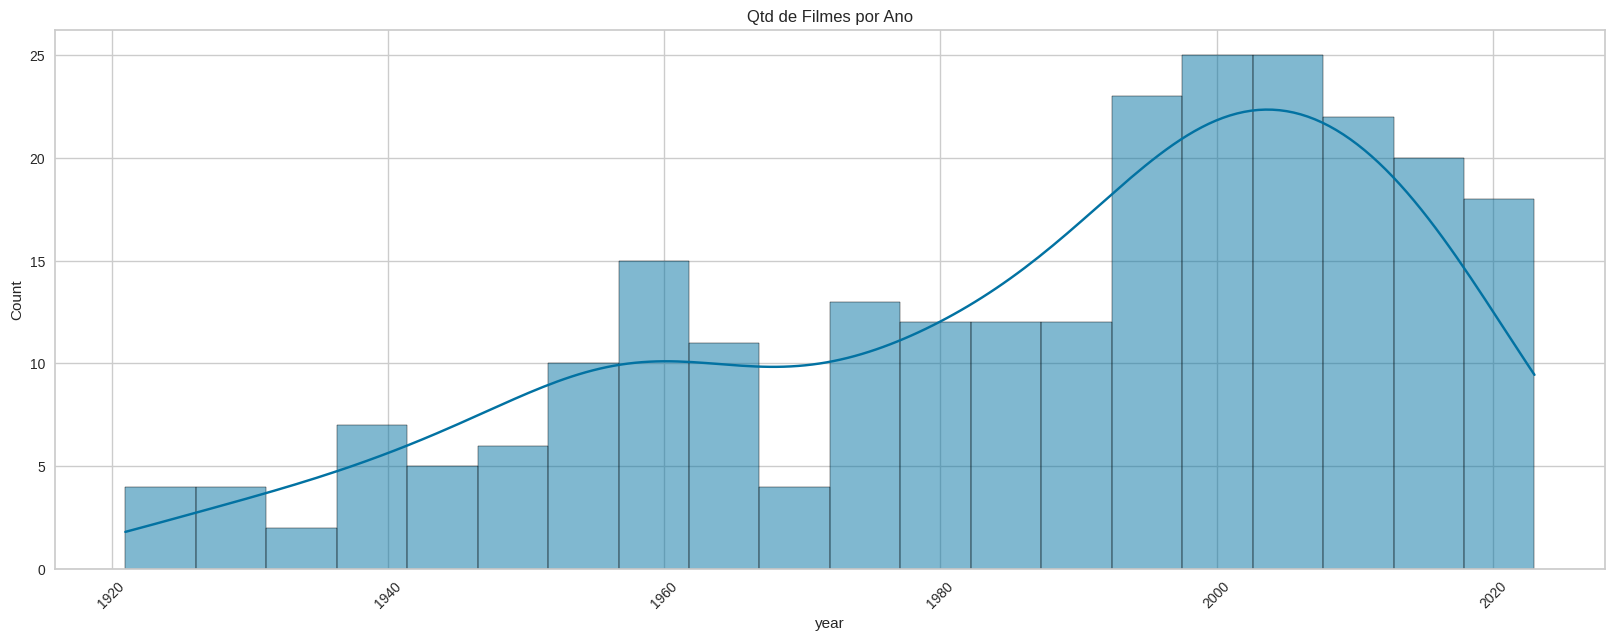

In [ ]:
plt.figure(figsize = (20,7))
sns.histplot( df,
              x = 'year',
              kde = True, bins = 20).set_title('Qtd de Filmes por Ano')
plt.xticks(rotation=45)
plt.show()

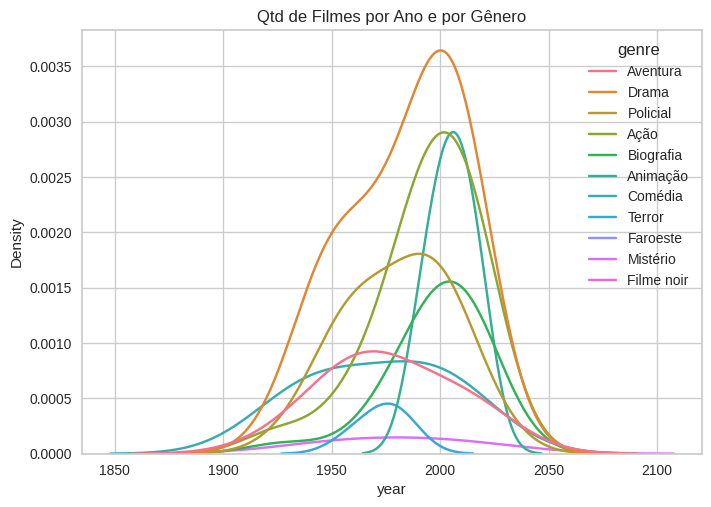

In [ ]:
sns.kdeplot( df, x = 'year', hue = 'genre', bw_adjust = 1.5, warn_singular = False).set_title('Qtd de Filmes por Ano e por Gênero')
plt.show()

# Pré-processamento de texto

In [ ]:
#convert sinopses to lowercase
df_processed = df.copy()
df_processed['sinopse'] = df_processed['sinopse'].str.lower()
df_processed['sinopse'].head()

0    viver na terra da barbie é ser um ser perfeito...
1    dois homens presos se reúnem ao longo de vário...
2    o patriarca idoso de uma dinastia do crime org...
3    quando a ameaça conhecida como o coringa surge...
4    em 1950, michael corleone, agora à frente da f...
Name: sinopse, dtype: object

In [ ]:
def qty_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

In [ ]:
### Feature Engineering
df_processed['word_count'] = df_processed['sinopse'].apply(qty_words).astype('int64')
df_processed.head()

title_pt                     title_en  year  rating  \
0                          Barbie                       Barbie  2023     7.4   
1           Um Sonho de Liberdade  1. The Shawshank Redemption  1994     9.3   
2               O Poderoso Chefão             2. The Godfather  1972     9.2   
3  Batman: O Cavaleiro das Trevas           3. The Dark Knight  2008     9.0   
4            O Poderoso Chefão II     4. The Godfather Part II  1974     9.0   

      genre                                            sinopse  word_count  
0  Aventura  viver na terra da barbie é ser um ser perfeito...          29  
1     Drama  dois homens presos se reúnem ao longo de vário...          21  
2  Policial  o patriarca idoso de uma dinastia do crime org...          20  
3      Ação  quando a ameaça conhecida como o coringa surge...          33  
4  Policial  em 1950, michael corleone, agora à frente da f...          41

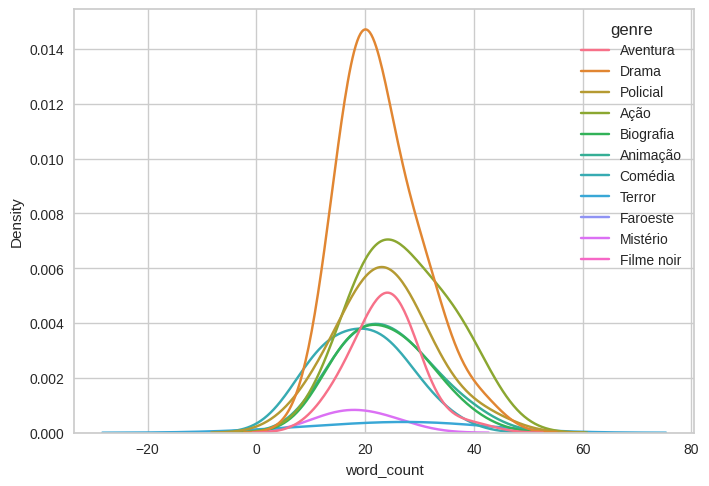

In [ ]:
sns.kdeplot( df_processed, x = 'word_count', hue = 'genre', bw_adjust = 1.5, warn_singular = False)
plt.show()

## Nuvem de palavras

### Antes de remover as stopwords

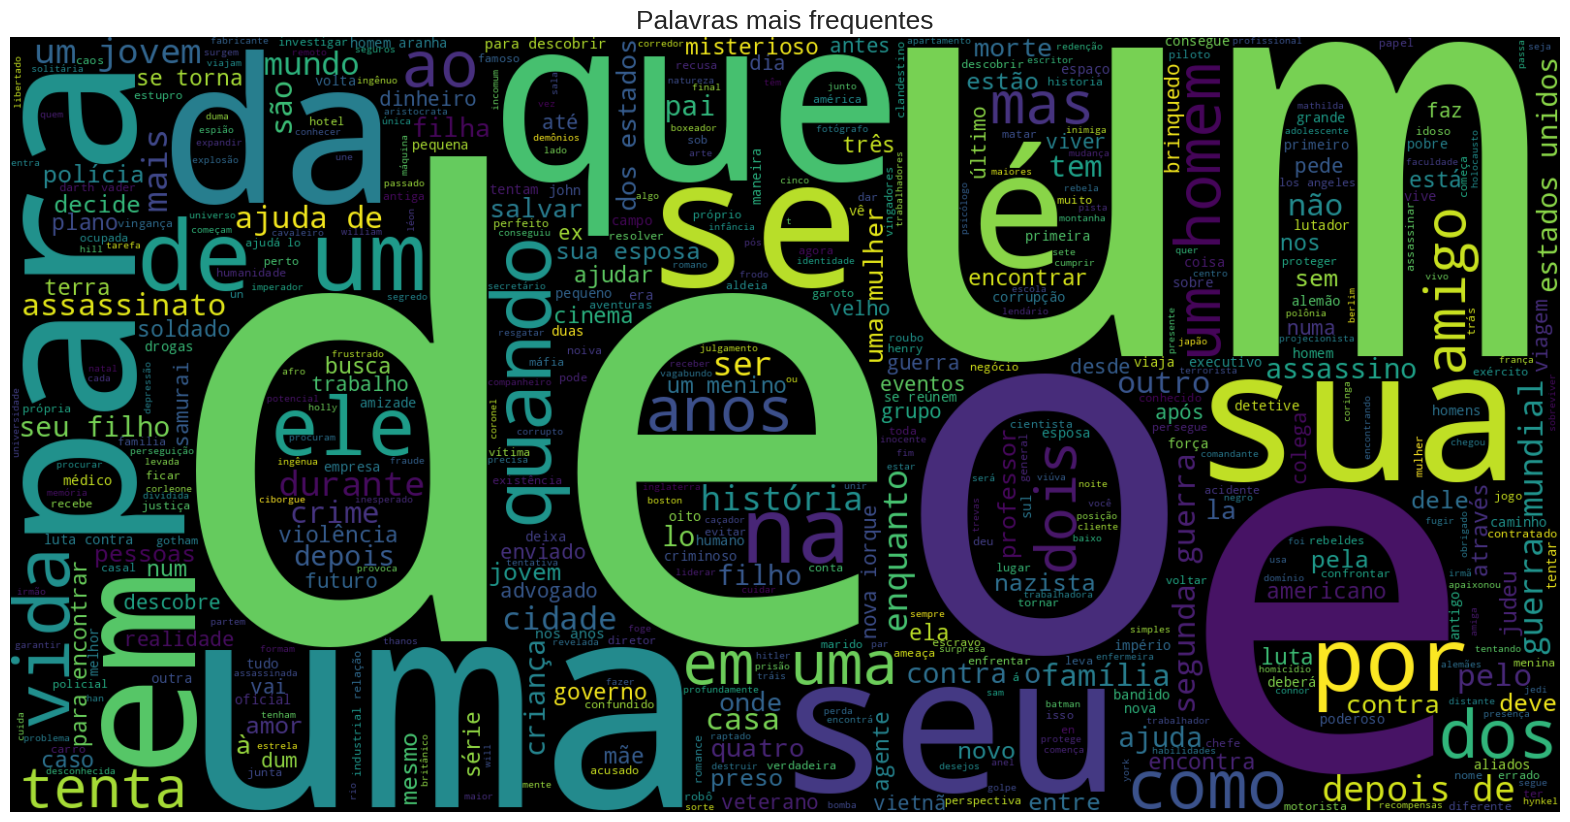

In [ ]:
text = ' '.join([phrase for phrase in df_processed['sinopse']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes', fontsize = 19)
plt.show()

### Após remoção das stopwords

In [ ]:
import nltk
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('portuguese')
print(stopwords)

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvésse

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


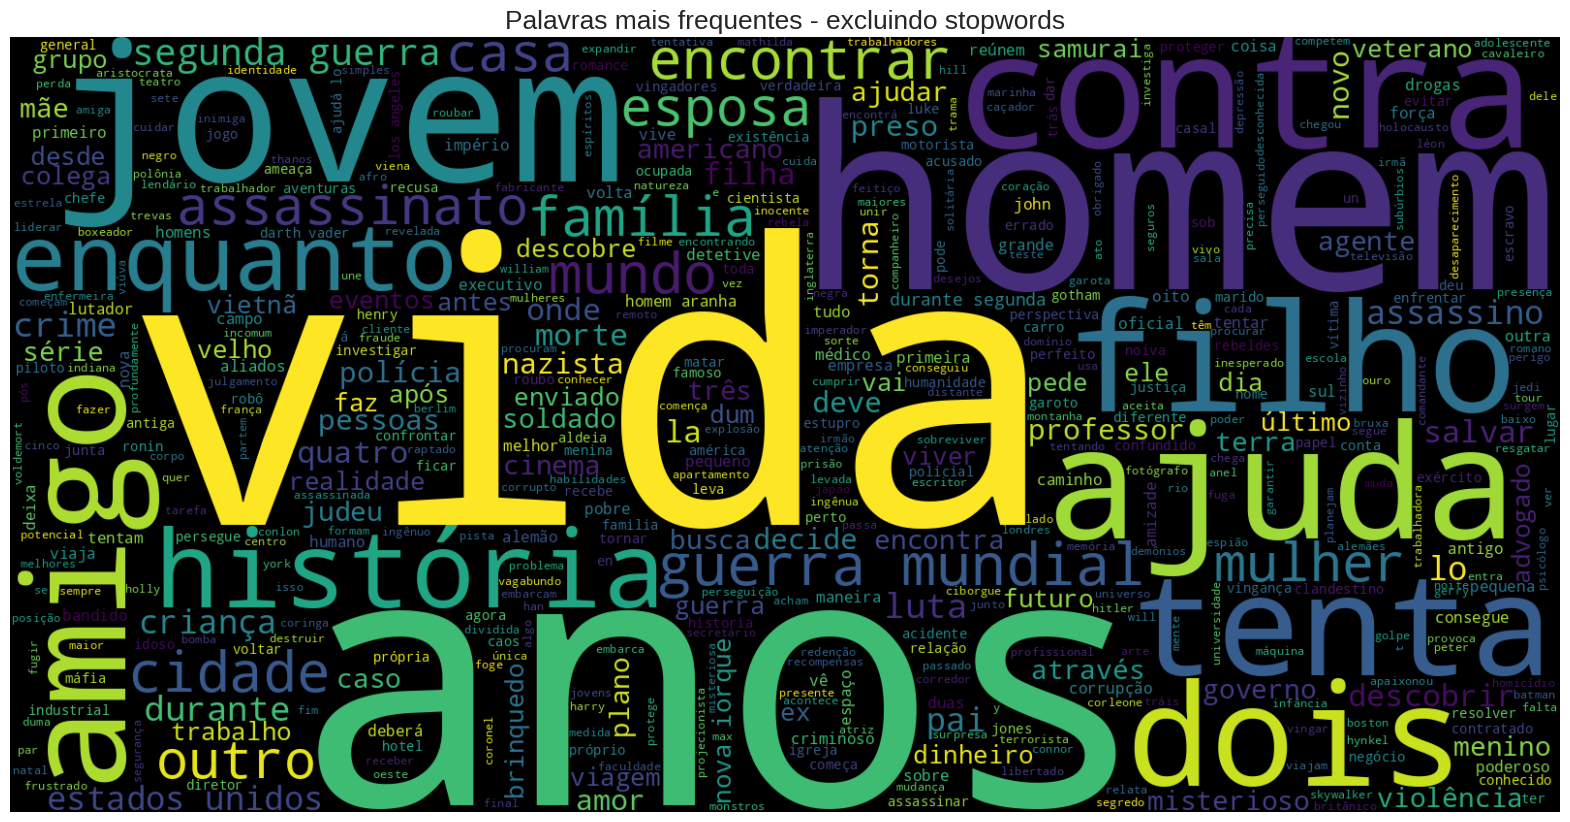

In [ ]:
df_processed['sinopse_no_stopwords'] = df_processed['sinopse'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
text = ' '.join([phrase for phrase in df_processed['sinopse_no_stopwords']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes - excluindo stopwords', fontsize = 19)
plt.show()

## Aplicando TF-IDF
Term Frequency-Inverse Document Frequency

O TF-IDF define a importância de um termo levando em consideração a importância desse termo em um único documento e dimensionando-o por sua importância em todos os documentos.

In [ ]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95, ngram_range = (1,2))
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df_processed['sinopse_no_stopwords'])

print(X.shape)
X.toarray()

(250, 87)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.70710678],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# AutoML | PyCaret - Clustering

## Setup

In [ ]:
s = setup(data = X.toarray(),
          session_id = 123)

# Create Model

In [ ]:
mdl_kmeans = create_model('kmeans')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
mdl_dbscan = create_model('dbscan')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
mdl_meanshift = create_model('meanshift')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

# Assign Model

In [ ]:
# models()

In [ ]:
df_kmeans = assign_model(mdl_kmeans)
display(df_kmeans.Cluster.value_counts())
df_kmeans

Cluster 0    212
Cluster 1     13
Cluster 2     13
Cluster 3     12
Name: Cluster, dtype: int64

feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0          0.0        0.0        0.0        0.0        0.0        0.0   
1          0.0        0.0        0.0        0.0        0.0        0.0   
2          0.0        0.0        0.0        0.0        0.0        0.0   
3          0.0        0.0        0.0        0.0        0.0        0.0   
4          0.0        0.0        0.0        0.0        0.0        0.0   
..         ...        ...        ...        ...        ...        ...   
245        0.0        0.0        0.0        0.0        0.0        0.0   
246        0.0        0.0        0.0        0.0        0.0        0.0   
247        0.0        0.0        0.0        0.0        0.0        0.0   
248        0.0        0.0        0.0        0.0        0.0        0.0   
249        0.0        0.0        0.0        0.0        0.0        0.0   

     feature_7  feature_8  feature_9  feature_10  ...  feature_79  feature_80  \
0     0.000000        0.0        0.0         0.0  ...         0.0         0.0   
1     0.499298        0.0        0.0         0.0  ...         0.0         0.0   
2     0.000000        0.0        0.0         0.0  ...         0.0         0.0   
3     0.000000        0.0        0.0         0.0  ...         0.0         0.0   
4     0.000000        0.0        0.0         0.0  ...         0.0         0.0   
..         ...        ...        ...         ...  ...         ...         ...   
245   0.340978        0.0        0.0         0.0  ...         0.0         0.0   
246   0.000000        0.0        0.0         0.0  ...         0.0         0.0   
247   0.000000        0.0        0.0         0.0  ...         0.0         0.0   
248   0.000000        0.0        0.0         0.0  ...         0.0         0.0   
249   0.000000        0.0        0.0         0.0  ...         0.0         0.0   

     feature_81  feature_82  feature_83  feature_84  feature_85  feature_86  \
0           0.0    0.000000         0.0         0.0         0.0         0.0   
1           0.0    0.000000         0.0         0.0         0.0         0.0   
2           0.0    0.000000         0.0         0.0         0.0         0.0   
3           0.0    0.000000         0.0         0.0         0.0         0.0   
4           0.0    0.000000         0.0         0.0         0.0         0.0   
..          ...         ...         ...         ...         ...         ...   
245         0.0    0.424756         0.0         0.0         0.0         0.0   
246         0.0    0.000000         0.0         0.0         0.0         0.0   
247         0.0    0.000000         0.0         1.0         0.0         0.0   
248         0.0    0.000000         0.0         0.0         0.0         0.0   
249         0.0    0.000000         0.0         0.0         0.0         0.0   

     feature_87    Cluster  
0      0.707107  Cluster 0  
1      0.000000  Cluster 0  
2      0.000000  Cluster 0  
3      0.000000  Cluster 0  
4      0.000000  Cluster 0  
..          ...        ...  
245    0.000000  Cluster 0  
246    0.000000  Cluster 0  
247    0.000000  Cluster 0  
248    0.000000  Cluster 0  
249    0.000000  Cluster 0  

[250 rows x 88 columns]

In [ ]:
df_db = assign_model(mdl_dbscan)
df_db.Cluster.value_counts()

Cluster -1    241
Cluster 0       9
Name: Cluster, dtype: int64

In [ ]:
df_meanshift = assign_model(mdl_meanshift)
df_meanshift.Cluster.value_counts()

Cluster 0    250
Name: Cluster, dtype: int64

# Analyze Models

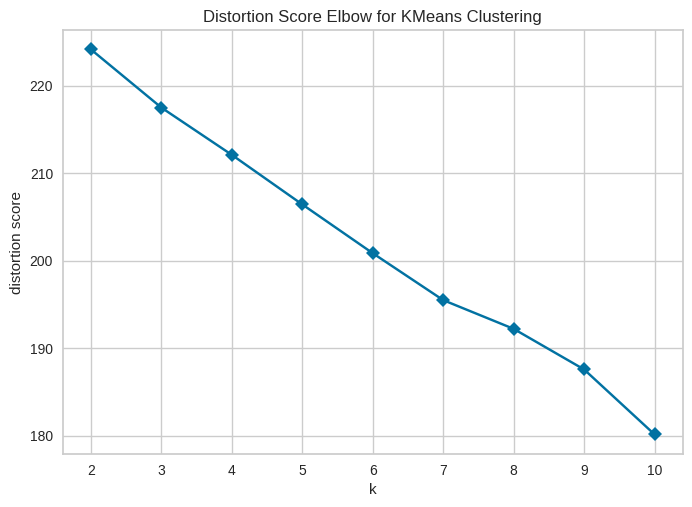

In [ ]:
plot_model(mdl_kmeans, plot = 'elbow')

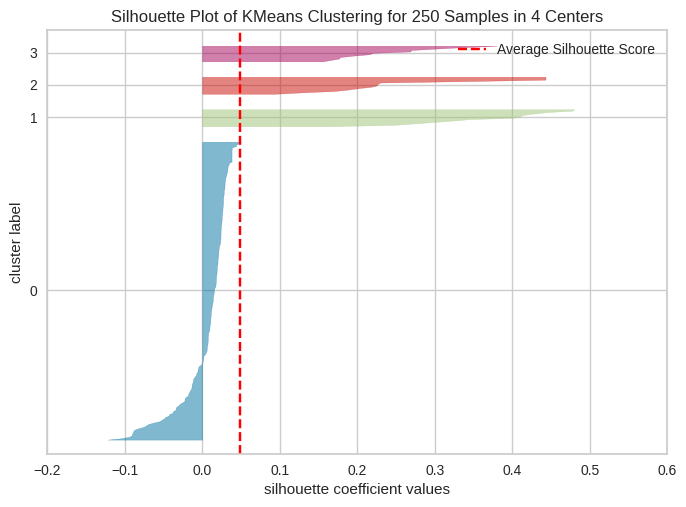

In [ ]:
plot_model(mdl_kmeans, plot = 'silhouette')

In [ ]:
plot_model(mdl_kmeans, plot = 'distribution')

In [ ]:
plot_model(mdl_kmeans, plot = 'cluster')

In [ ]:
plot_model(mdl_kmeans, plot = 'tsne')

In [ ]:
evaluate_model(mdl_kmeans)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# Filmes por cluster

In [ ]:
df_processed['cluster'] = df_kmeans['Cluster']
df_processed

title_pt                     title_en  year  \
0                            Barbie                       Barbie  2023   
1             Um Sonho de Liberdade  1. The Shawshank Redemption  1994   
2                 O Poderoso Chefão             2. The Godfather  1972   
3    Batman: O Cavaleiro das Trevas           3. The Dark Knight  2008   
4              O Poderoso Chefão II     4. The Godfather Part II  1974   
..                              ...                          ...   ...   
245              Histórias Cruzadas                246. The Help  2011   
246      Quando Duas Mulheres Pecam                 247. Persona  1966   
247                 A Vida de Brian           248. Life of Brian  1979   
248                         Aladdin                 249. Aladdin  1992   
249                   As Diabólicas              250. Diabolique  1955   

     rating     genre                                            sinopse  \
0       7.4  Aventura  viver na terra da barbie é ser um ser perfeito...   
1       9.3     Drama  dois homens presos se reúnem ao longo de vário...   
2       9.2  Policial  o patriarca idoso de uma dinastia do crime org...   
3       9.0      Ação  quando a ameaça conhecida como o coringa surge...   
4       9.0  Policial  em 1950, michael corleone, agora à frente da f...   
..      ...       ...                                                ...   
245     8.1     Drama  uma aspirante a escritora durante o movimento ...   
246     8.1     Drama  uma enfermeira é encarregada de uma atriz sile...   
247     8.0   Comédia  nascido no natal original no estábulo ao lado ...   
248     8.0  Animação  um menino de rua bondoso e um vizir competem p...   
249     8.1  Policial  a esposa e a amante de um diretor de escola de...   

     word_count                               sinopse_no_stopwords    cluster  
0            29  viver terra barbie perfeito lugar perfeito. me...  Cluster 0  
1            21  dois homens presos reúnem longo vários anos, e...  Cluster 0  
2            20  patriarca idoso dinastia crime organizado tran...  Cluster 0  
3            33  ameaça conhecida coringa surge passado, causa ...  Cluster 0  
4            41  1950, michael corleone, agora frente família, ...  Cluster 0  
..          ...                                                ...        ...  
245          32  aspirante escritora durante movimento direitos...  Cluster 0  
246          17  enfermeira encarregada atriz silenciosa descob...  Cluster 0  
247          20  nascido natal original estábulo lado jesus, br...  Cluster 0  
248          23  menino rua bondoso vizir competem lâmpada mági...  Cluster 0  
249          22  esposa amante diretor escola detestável planej...  Cluster 0  

[250 rows x 9 columns]

## % de Gêneros por Cluster

In [ ]:
fig = px.bar(df_processed.cluster.value_counts(),
             text_auto = True,
             title = 'Qtd de Filmes por Cluster',
             labels = {'index': 'Cluster #',
                       'value':'Qtd. de Filmes'})
fig.show()

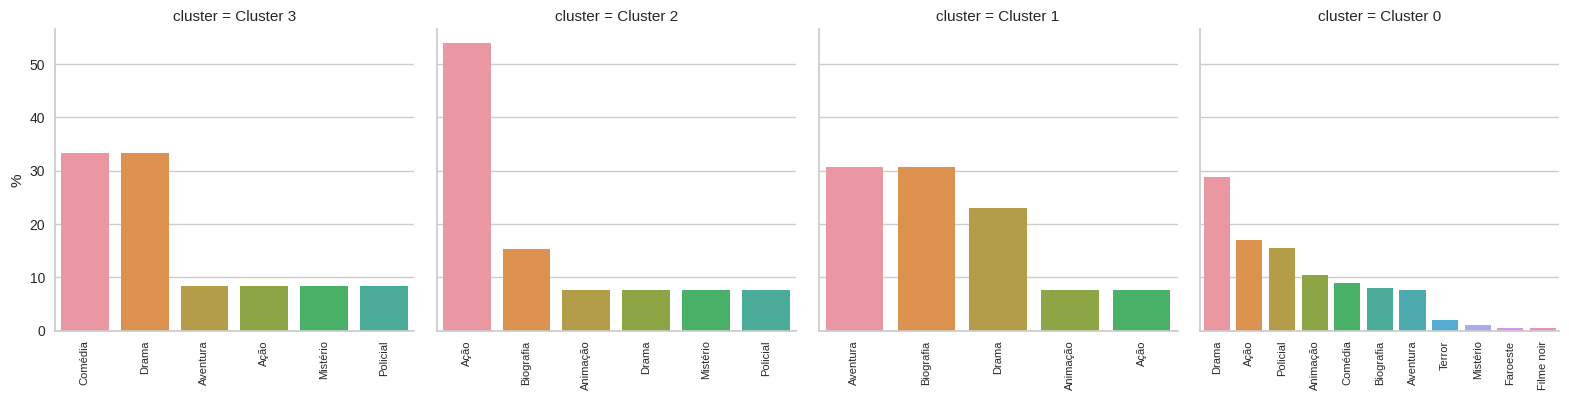

In [ ]:
df_plot = df_processed.groupby(['cluster', 'genre'])['title_pt'].count()
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'title_pt':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('cluster')['count'].transform('sum')
df_plot = df_plot.sort_values(['cluster', '%'], ascending = False).groupby('cluster').head(11)

fig = sns.catplot(
    data=df_plot, x="genre", y = "%", col="cluster",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 8);

## Ano de Lançamento por Cluster

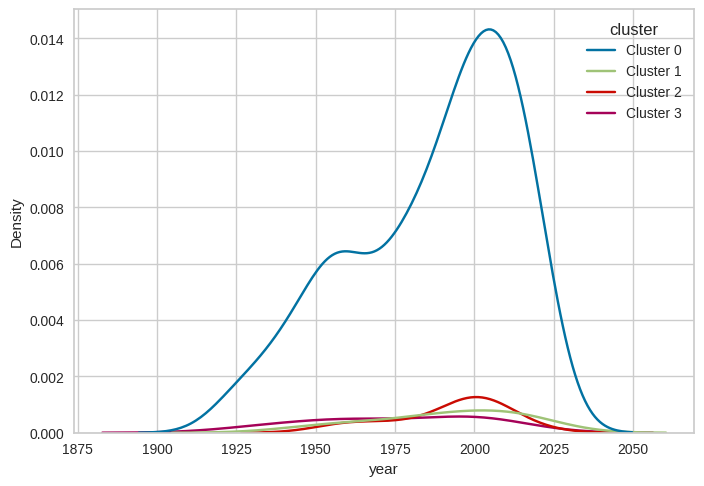

In [ ]:
sns.kdeplot(df_processed, x = 'year', hue = 'cluster');

## Radar | Gêneros por Cluster

In [ ]:
df_pivot = df_plot.copy()
df_pivot = df_pivot.pivot(index = 'cluster', columns = 'genre', values = '%')
df_pivot.fillna(0, inplace = True)
df_pivot = df_pivot.T.reset_index()
df_pivot.index.name = None
df_pivot

cluster       genre  Cluster 0  Cluster 1  Cluster 2  Cluster 3
0          Animação  10.377358   7.692308   7.692308   0.000000
1          Aventura   7.547170  30.769231   0.000000   8.333333
2              Ação  16.981132   7.692308  53.846154   8.333333
3         Biografia   8.018868  30.769231  15.384615   0.000000
4           Comédia   8.962264   0.000000   0.000000  33.333333
5             Drama  28.773585  23.076923   7.692308  33.333333
6          Faroeste   0.471698   0.000000   0.000000   0.000000
7        Filme noir   0.471698   0.000000   0.000000   0.000000
8          Mistério   0.943396   0.000000   7.692308   8.333333
9          Policial  15.566038   0.000000   7.692308   8.333333
10           Terror   1.886792   0.000000   0.000000   0.000000

In [ ]:
df_polar = df_pivot.melt(id_vars=['genre'])
df_polar.head()

genre    cluster      value
0   Animação  Cluster 0  10.377358
1   Aventura  Cluster 0   7.547170
2       Ação  Cluster 0  16.981132
3  Biografia  Cluster 0   8.018868
4    Comédia  Cluster 0   8.962264

In [ ]:
fig = px.line_polar(df_polar, r='value', theta='genre', color = 'cluster', line_close=True)
fig.show();

# Nuvem de Palavras por Cluster

Cluster 0


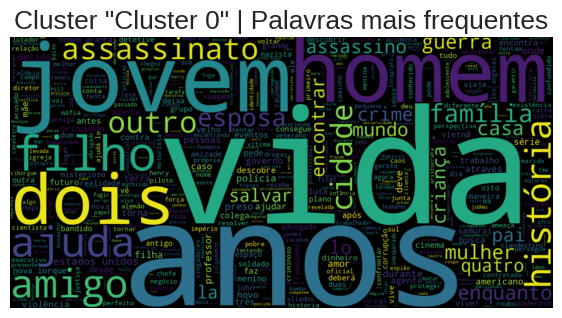

Cluster 1


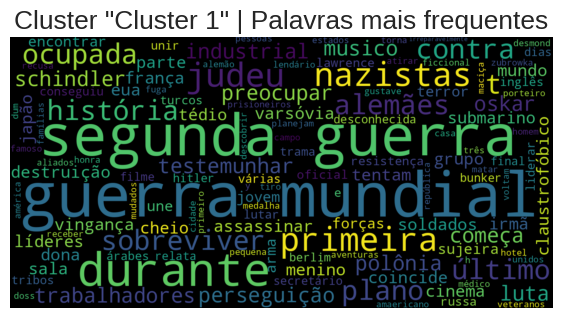

Cluster 2


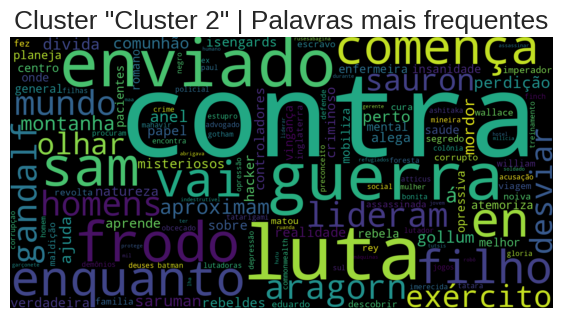

Cluster 3


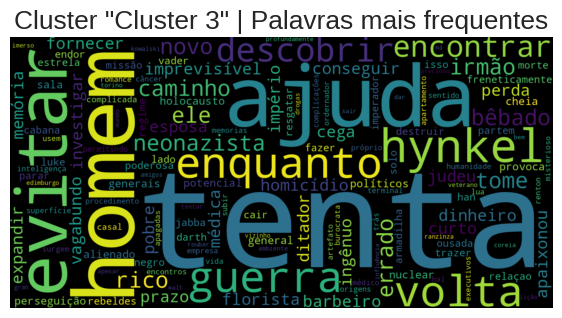

In [ ]:
def word_cloud_cluster(cluster:int):
  text = ' '.join([phrase for phrase in df_processed.loc[df_processed.cluster == cluster]['sinopse_no_stopwords']])
  plt.figure(figsize=(7,5), facecolor='None')
  wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Cluster "{cluster}" | Palavras mais frequentes', fontsize = 19)
  plt.show()
  return

list_clusters = df_processed.cluster.unique().tolist()
for c in list_clusters:
  print(c)
  word_cloud_cluster(c)

# Considerações Finais
* **Exercício: Reescrever as análises / conclusões devido a atualização da base**

#Conclusões

In [ ]:
#Escreva aqui as suas análises / conclusões

# Adicionando demais features do df all_movies ao X

In [ ]:
df_processed.shape

(250, 9)

In [ ]:
pd.DataFrame(X.toarray()).shape

(250, 87)

In [ ]:
df_all = pd.concat([
                    df_processed.drop(['cluster',
                                      #  'year',
                                       'title_pt',
                                       'title_en',
                                       'sinopse',
                                       'sinopse_no_stopwords',], axis = 1),
                    pd.DataFrame(X.toarray())
                   ]
                   , axis = 1
                   )
df_all

year  rating     genre  word_count    0    1    2    3    4    5  ...  \
0    2023     7.4  Aventura          29  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1    1994     9.3     Drama          21  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2    1972     9.2  Policial          20  0.0  0.0  0.0  0.0  0.0  0.0  ...   
3    2008     9.0      Ação          33  0.0  0.0  0.0  0.0  0.0  0.0  ...   
4    1974     9.0  Policial          41  0.0  0.0  0.0  0.0  0.0  0.0  ...   
..    ...     ...       ...         ...  ...  ...  ...  ...  ...  ...  ...   
245  2011     8.1     Drama          32  0.0  0.0  0.0  0.0  0.0  0.0  ...   
246  1966     8.1     Drama          17  0.0  0.0  0.0  0.0  0.0  0.0  ...   
247  1979     8.0   Comédia          20  0.0  0.0  0.0  0.0  0.0  0.0  ...   
248  1992     8.0  Animação          23  0.0  0.0  0.0  0.0  0.0  0.0  ...   
249  1955     8.1  Policial          22  0.0  0.0  0.0  0.0  0.0  0.0  ...   

           77   78   79   80        81   82   83   84   85        86  
0    0.707107  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.707107  
1    0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  
2    0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  
3    0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  
4    0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  
..        ...  ...  ...  ...       ...  ...  ...  ...  ...       ...  
245  0.000000  0.0  0.0  0.0  0.424756  0.0  0.0  0.0  0.0  0.000000  
246  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  
247  0.000000  0.0  0.0  0.0  0.000000  0.0  1.0  0.0  0.0  0.000000  
248  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  
249  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  

[250 rows x 91 columns]

# Get Dummies

In [ ]:
df_all = pd.get_dummies(df_all)
df_all

year  rating  word_count    0    1    2    3    4    5         6  ...  \
0    2023     7.4          29  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
1    1994     9.3          21  0.0  0.0  0.0  0.0  0.0  0.0  0.499298  ...   
2    1972     9.2          20  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
3    2008     9.0          33  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
4    1974     9.0          41  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
..    ...     ...         ...  ...  ...  ...  ...  ...  ...       ...  ...   
245  2011     8.1          32  0.0  0.0  0.0  0.0  0.0  0.0  0.340978  ...   
246  1966     8.1          17  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
247  1979     8.0          20  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
248  1992     8.0          23  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
249  1955     8.1          22  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   

     genre_Aventura  genre_Ação  genre_Biografia  genre_Comédia  genre_Drama  \
0                 1           0                0              0            0   
1                 0           0                0              0            1   
2                 0           0                0              0            0   
3                 0           1                0              0            0   
4                 0           0                0              0            0   
..              ...         ...              ...            ...          ...   
245               0           0                0              0            1   
246               0           0                0              0            1   
247               0           0                0              1            0   
248               0           0                0              0            0   
249               0           0                0              0            0   

     genre_Faroeste  genre_Filme noir  genre_Mistério  genre_Policial  \
0                 0                 0               0               0   
1                 0                 0               0               0   
2                 0                 0               0               1   
3                 0                 0               0               0   
4                 0                 0               0               1   
..              ...               ...             ...             ...   
245               0                 0               0               0   
246               0                 0               0               0   
247               0                 0               0               0   
248               0                 0               0               0   
249               0                 0               0               1   

     genre_Terror  
0               0  
1               0  
2               0  
3               0  
4               0  
..            ...  
245             0  
246             0  
247             0  
248             0  
249             0  

[250 rows x 101 columns]

# Setup

In [ ]:
s = setup(data = df_all,
          session_id = 123,
          normalize = True,
          normalize_method = 'minmax')

In [ ]:
mdl_kmeans_all = create_model('kmeans')

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

# Evaluate Model

In [ ]:
evaluate_model(mdl_kmeans_all)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
df_kmeans_all = assign_model(mdl_kmeans_all)
df_kmeans_all.rename(columns = {'Cluster': 'cluster'}, inplace = True)
df_kmeans_all.columns.tolist()

['year',
 'rating',
 'word_count',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 'genre_Animação',
 'genre_Aventura',
 'genre_Ação',
 'genre_Biografia',
 'genre_Comédia',
 'genre_Drama',
 'genre_Faroeste',
 'genre_Filme noir',
 'genre_Mistério',
 'genre_Policial',
 'genre_Terror',
 'cluster']

In [ ]:
df_kmeans_all['genre'] = df_processed['genre'].copy()
df_kmeans_all['sinopse_no_stopwords'] = df_processed['sinopse_no_stopwords'].copy()
df_kmeans_all

year  rating  word_count    0    1    2    3    4    5         6  ...  \
0    2023     7.4          29  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
1    1994     9.3          21  0.0  0.0  0.0  0.0  0.0  0.0  0.499298  ...   
2    1972     9.2          20  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
3    2008     9.0          33  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
4    1974     9.0          41  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
..    ...     ...         ...  ...  ...  ...  ...  ...  ...       ...  ...   
245  2011     8.1          32  0.0  0.0  0.0  0.0  0.0  0.0  0.340978  ...   
246  1966     8.1          17  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
247  1979     8.0          20  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
248  1992     8.0          23  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   
249  1955     8.1          22  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  ...   

     genre_Comédia  genre_Drama  genre_Faroeste  genre_Filme noir  \
0                0            0               0                 0   
1                0            1               0                 0   
2                0            0               0                 0   
3                0            0               0                 0   
4                0            0               0                 0   
..             ...          ...             ...               ...   
245              0            1               0                 0   
246              0            1               0                 0   
247              1            0               0                 0   
248              0            0               0                 0   
249              0            0               0                 0   

     genre_Mistério  genre_Policial  genre_Terror    cluster     genre  \
0                 0               0             0  Cluster 1  Aventura   
1                 0               0             0  Cluster 0     Drama   
2                 0               1             0  Cluster 1  Policial   
3                 0               0             0  Cluster 2      Ação   
4                 0               1             0  Cluster 1  Policial   
..              ...             ...           ...        ...       ...   
245               0               0             0  Cluster 0     Drama   
246               0               0             0  Cluster 0     Drama   
247               0               0             0  Cluster 1   Comédia   
248               0               0             0  Cluster 3  Animação   
249               0               1             0  Cluster 1  Policial   

                                  sinopse_no_stopwords  
0    viver terra barbie perfeito lugar perfeito. me...  
1    dois homens presos reúnem longo vários anos, e...  
2    patriarca idoso dinastia crime organizado tran...  
3    ameaça conhecida coringa surge passado, causa ...  
4    1950, michael corleone, agora frente família, ...  
..                                                 ...  
245  aspirante escritora durante movimento direitos...  
246  enfermeira encarregada atriz silenciosa descob...  
247  nascido natal original estábulo lado jesus, br...  
248  menino rua bondoso vizir competem lâmpada mági...  
249  esposa amante diretor escola detestável planej...  

[250 rows x 104 columns]

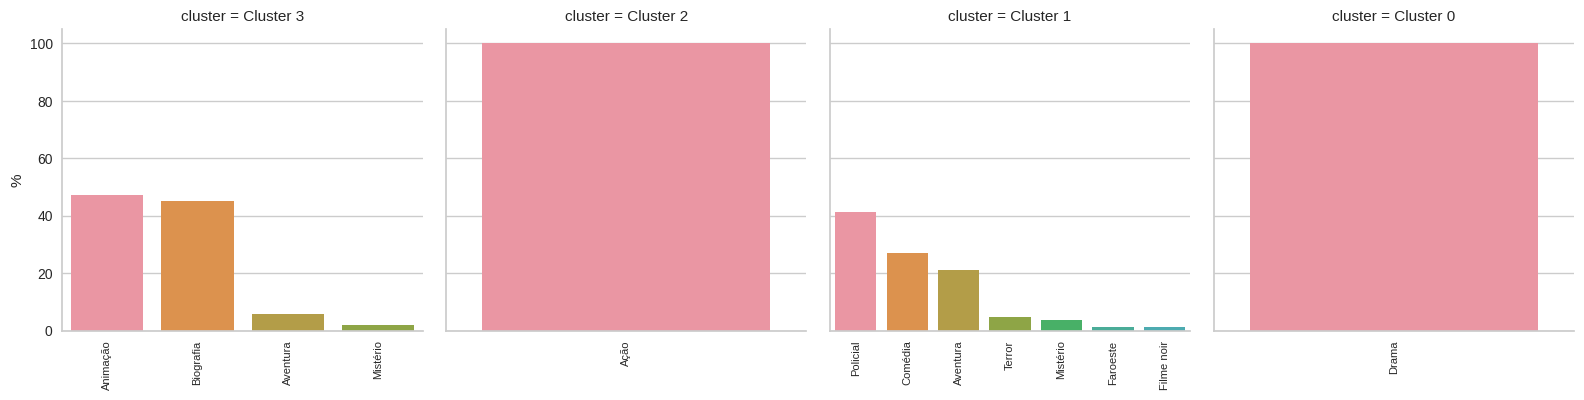

In [ ]:


df_plot = df_kmeans_all.groupby(['cluster', 'genre'])['rating'].count()

df_plot = df_plot.reset_index()
df_plot.rename(columns={'rating':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('cluster')['count'].transform('sum')
df_plot = df_plot.sort_values(['cluster', '%'], ascending = False).groupby('cluster').head(11)

fig = sns.catplot(
    data=df_plot, x="genre", y = "%", col="cluster",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 8);

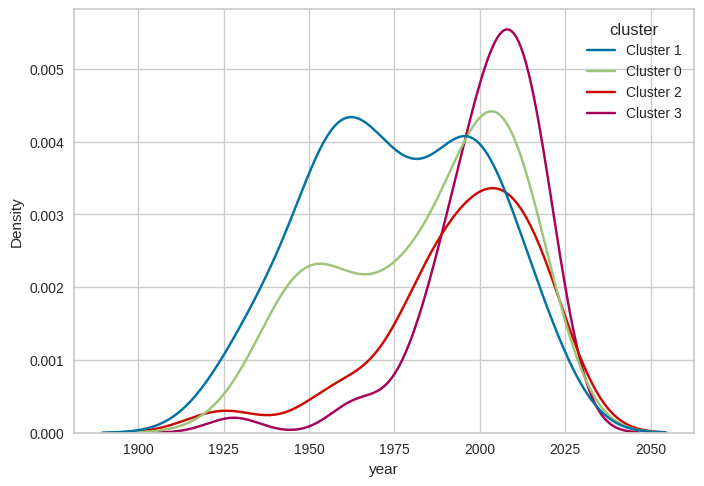

In [ ]:
df_mdl = df_kmeans_all.copy()
df_mdl['year'] = df_processed['year'].copy()
sns.kdeplot(df_mdl, x = 'year', hue = 'cluster');

In [ ]:
df_pivot = df_plot.copy()
df_pivot = df_pivot.pivot(index = 'cluster', columns = 'genre', values = '%')
df_pivot.fillna(0, inplace = True)
df_pivot = df_pivot.T.reset_index()
df_pivot.index.name = None
df_pivot

cluster       genre  Cluster 0  Cluster 1  Cluster 2  Cluster 3
0          Animação        0.0   0.000000        0.0  47.058824
1          Aventura        0.0  21.176471        0.0   5.882353
2              Ação        0.0   0.000000      100.0   0.000000
3         Biografia        0.0   0.000000        0.0  45.098039
4           Comédia        0.0  27.058824        0.0   0.000000
5             Drama      100.0   0.000000        0.0   0.000000
6          Faroeste        0.0   1.176471        0.0   0.000000
7        Filme noir        0.0   1.176471        0.0   0.000000
8          Mistério        0.0   3.529412        0.0   1.960784
9          Policial        0.0  41.176471        0.0   0.000000
10           Terror        0.0   4.705882        0.0   0.000000

In [ ]:
df_polar = df_pivot.melt(id_vars=['genre'])
df_polar.head()

genre    cluster  value
0   Animação  Cluster 0    0.0
1   Aventura  Cluster 0    0.0
2       Ação  Cluster 0    0.0
3  Biografia  Cluster 0    0.0
4    Comédia  Cluster 0    0.0

In [ ]:
fig = px.line_polar(df_polar, r='value', theta='genre', color = 'cluster', line_close=True)
fig.show();

Cluster 1


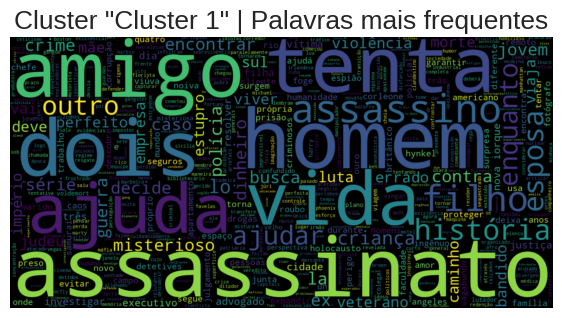

Cluster 0


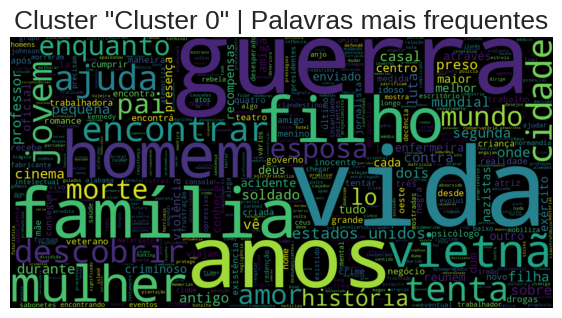

Cluster 2


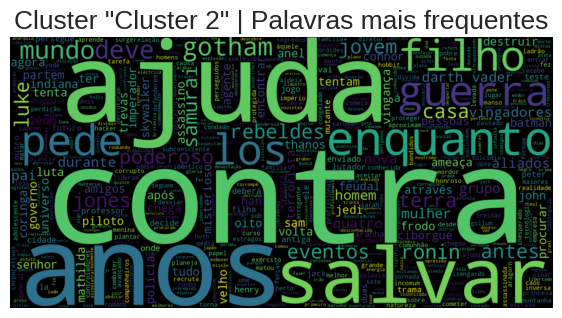

Cluster 3


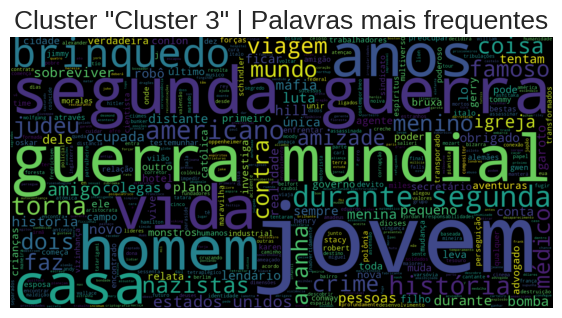

In [ ]:
def word_cloud_cluster(cluster:int):
  text = ' '.join([phrase for phrase in df_mdl.loc[df_mdl.cluster == cluster]['sinopse_no_stopwords']])
  plt.figure(figsize=(7,5), facecolor='None')
  wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Cluster "{cluster}" | Palavras mais frequentes', fontsize = 19)
  plt.show()
  return

list_clusters = df_mdl.cluster.unique().tolist()
for c in list_clusters:
  print(c)
  word_cloud_cluster(c)